In [3]:
import numpy as np
import pandas as pd
import cv2
import os
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Input
from keras.applications import EfficientNetB0
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [5]:
 
train_img_dir = r'dataset/train/images'
train_labels_dir = r'dataset/train/labels'

 
labels_file_name = os.listdir(train_labels_dir)
labels_file_name.sort()

# Extract labels from filenames and preprocess them
labels = [label.split('_')[0].split('-')[0] for label in labels_file_name]
labels = np.array(labels, dtype='object')
labels[labels == 'Screenshot'] = '14'  

# Encode labels into numerical values
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

# Map numerical labels to actual class names (you can adjust these as needed)
label_mapping = {
    0: 'SPEED LIMIT 20', 
    1: 'SPEED LIMIT 30', 
    2: 'STOP', 
    3: 'SPEED LIMIT 50', 
    4: 'SPEED-LIMIT-60', 
    5: 'SPEED LIMIT 70', 
    6: 'SPEED-LIMIT-80', 
    7: 'SPEED LIMIT 100', 
    8: 'SPEED LIMIT 120'
}

# Preprocess images (resize, normalize)
images_path_names = sorted(glob.glob(os.path.join(train_img_dir, '*')))
preprocessed_images = []

for image_file in images_path_names:
    img = cv2.imread(image_file)
    img = cv2.resize(img, (96,96))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32') / 255.0  # Normalize pixel values
    preprocessed_images.append(img)

X = np.array(preprocessed_images)
y = np.array(labels)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

In [7]:
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization, ReLU, Add
from tensorflow.keras.models import Model

def resnet_block(x, filters, kernel_size=(3, 3), stride=1):
    # Shortcut connection
    shortcut = x

    # First convolution layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
 
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    
    x = Add()([x, shortcut])
    x = ReLU()(x)  

    return x

def create_custom_resnet(input_shape, num_classes):
    # Input layer
    input_tensor = Input(shape=input_shape)

    # Initial Conv Layer
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # ResNet blocks
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 128)   
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = resnet_block(x, 128)
    x = resnet_block(x, 256)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = resnet_block(x, 256)

    # Global Average Pooling
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)

    # Output layer
    output = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=input_tensor, outputs=output)

    return model

# Define input shape and number of classes
input_shape = (96, 96, 3)  # Adjust the input size as necessary
num_classes = 9

# Create the custom ResNet-like model
model = create_custom_resnet(input_shape, num_classes)

 
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 48, 48, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 48, 48, 64)           0         ['batch_normalization[0][0

In [8]:
# Learning rate schedule
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9
)

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define model checkpoints for saving the best model based on accuracy and loss
checkpoint_accuracy = ModelCheckpoint(
    filepath='checkpoint_accuracy.h5',  
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,   
    mode='max',
    verbose=1
)

checkpoint_loss = ModelCheckpoint(
    filepath='checkpoint_loss.h5',  
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,   
    mode='min',
    verbose=1
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Fit the model with the corrected callbacks
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint_accuracy, checkpoint_loss, early_stopping]
)


Epoch 1/50
63/63 [==============================] - ETA: 0s - loss: 2.2449 - accuracy: 0.2411
Epoch 1: val_accuracy improved from -inf to 0.12108, saving model to checkpoint_accuracy.h5

Epoch 1: val_loss improved from inf to 2.20893, saving model to checkpoint_loss.h5
63/63 [==============================] - 71s 1s/step - loss: 2.2449 - accuracy: 0.2411 - val_loss: 2.2089 - val_accuracy: 0.1211
Epoch 2/50
63/63 [==============================] - ETA: 0s - loss: 1.7075 - accuracy: 0.3635
Epoch 2: val_accuracy did not improve from 0.12108

Epoch 2: val_loss did not improve from 2.20893
63/63 [==============================] - 87s 1s/step - loss: 1.7075 - accuracy: 0.3635 - val_loss: 2.2134 - val_accuracy: 0.1211
Epoch 3/50
63/63 [==============================] - ETA: 0s - loss: 1.5136 - accuracy: 0.4333
Epoch 3: val_accuracy did not improve from 0.12108

Epoch 3: val_loss did not improve from 2.20893
63/63 [==============================] - 84s 1s/step - loss: 1.5136 - accuracy: 0.4333

In [22]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


7/7 [==============================] - 2s 222ms/step - loss: 0.0672 - accuracy: 0.9731
Test Loss: 0.0672214925289154, Test Accuracy: 0.9730941653251648


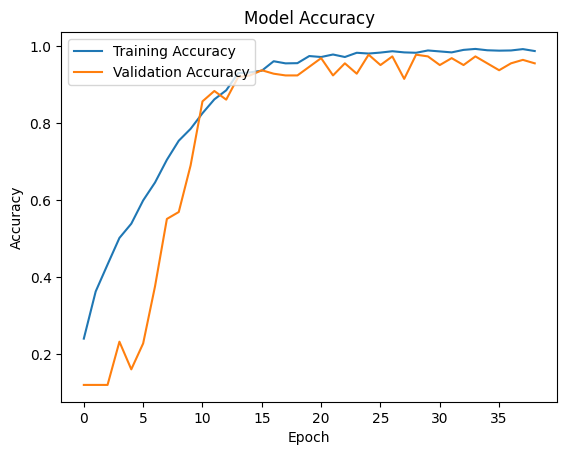

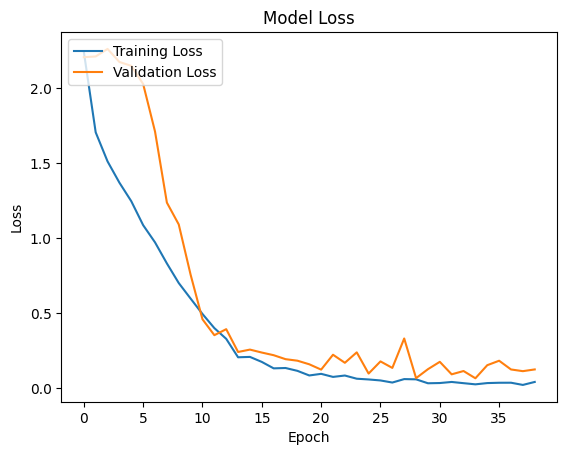

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

7/7 [==============================] - 2s 203ms/step


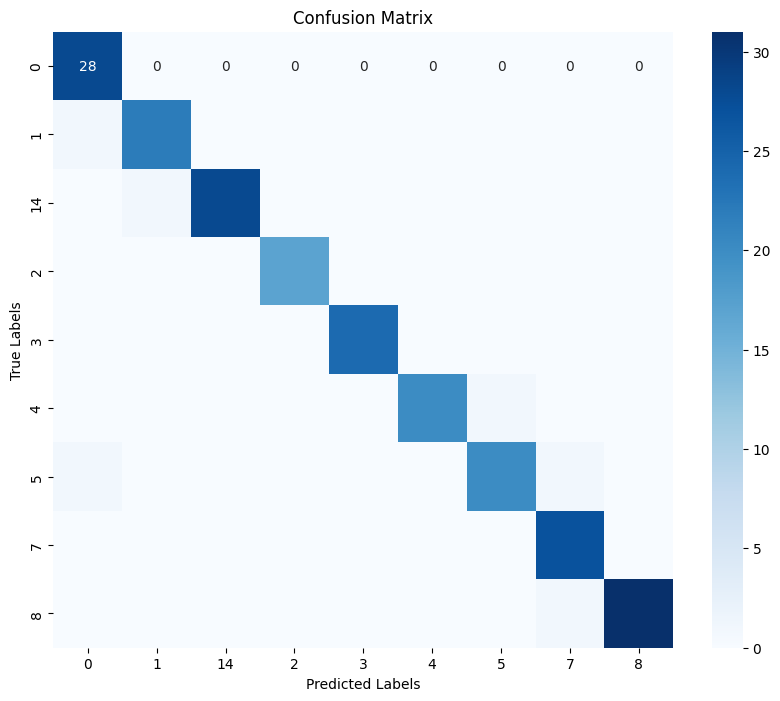

In [24]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [29]:
# Save the model
model.save('Road_Sign_Model_resnet.h5')

In [9]:
from tensorflow.keras.models import load_model

# Load a previously saved model
model = load_model('Road_Sign_Model_resnet.h5')

# If you want to see the model summary after loading
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d_22 (Conv2D)          (None, 48, 48, 64)           9472      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_22 (Ba  (None, 48, 48, 64)           256       ['conv2d_22[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_19 (ReLU)             (None, 48, 48, 64)           0         ['batch_normalization_22

7/7 [==============================] - 1s 144ms/step


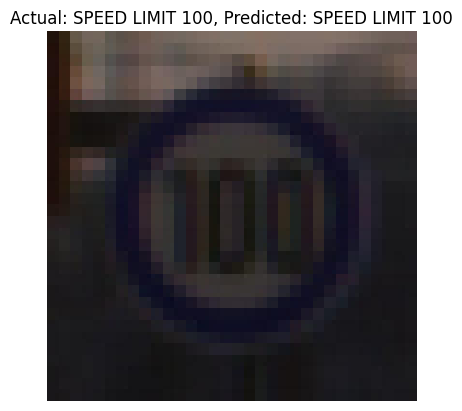

Precision: 0.9772
Recall: 0.9717
F1 Score: 0.9727


In [13]:
# Load and preprocess test images
test_images_dir = r'dataset/test/images'
test_labels_dir = r'dataset/test/labels'
test_labels_file_name = sorted(os.listdir(test_labels_dir))

# Process the labels for test set
test_labels = [label.split('_')[0].split('-')[0] for label in test_labels_file_name]
test_labels = np.array(test_labels, dtype='object')
test_labels[test_labels == 'Screenshot'] = '14'
test_labels = encoder.transform(test_labels)

# Load and preprocess images
test_images_path_names = sorted(glob.glob(os.path.join(test_images_dir, '*')))
test_preprocessed_images = []

for image_file in test_images_path_names:
    img = cv2.imread(image_file)
    img = cv2.resize(img, (96, 96))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32') / 255.0
    test_preprocessed_images.append(img)

test_images = np.array(test_preprocessed_images)

# Evaluate on test images
model.evaluate(test_images, test_labels, verbose=1)
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = [label_mapping[index] for index in predicted_labels]
test_labels = [label_mapping[index] for index in test_labels]

# Visualize a sample prediction
i = 180

plt.imshow(test_images[i])
plt.title(f'Actual: {test_labels[i]}, Predicted: {predicted_labels[i]}')
plt.axis('off')
plt.show()

# Calculate evaluation metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')
f1 = f1_score(test_labels, predicted_labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

